# Predict income

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import random
pd.options.display.max_columns = 42

# Useful functions

In [2]:
def compute_corr_matrix_continuous(dataframe, list_of_columns):
    """
    compute correlation matrix with specified columns
    """
    compute_corr_matrix = pd.DataFrame()
    for column in list_of_columns:
        compute_corr_matrix[column] = dataframe[column]
    return compute_corr_matrix.corr(method='pearson')


def compute_corr_matrix_categorical(dataframe, list_categorical):
    df_dummies = pd.get_dummies(dataframe[list_categorical])
    df_new = pd.concat([dataframe["income"], df_dummies], axis=1)
    x = df_new.values
    answer_df = pd.DataFrame(columns=list(df_new))
    answer_df.loc[0] = np.corrcoef(x.T)[0]
    return answer_df

def analyse_continuous_column(dataframe, column_name):
    dataframe[column_name].value_counts().sort_index().plot(kind='line')
    return compute_corr_matrix_continuous(dataframe, [column_name, 'income'])

def analyse_categorical_column(dataframe, column_name):
    dataframe[column_name].value_counts().plot(kind='bar')
    return compute_corr_matrix_categorical(dataframe, [column_name])

def generate_accuracy(prediction, real):
    """
    compute accuracy comparing your prediction and the real value
    """
    if prediction.size != real.size:
        raise ValueError('prediction and real have not the same size')
    count = 0
    size = prediction.size
    for i in range(size):
        if prediction[i] == real[i]:
            count += 1
    return count/size

def evaluate_bad_performance(prediction, real):
    """
    This function returns a list of value on which we have generate a bad prediction. This will allows us to generate 
    bad prediction repartition
    """
    if prediction.size != real.size:
        raise ValueError('prediction and real have not the same size')
    bad_perf = []
    size = prediction.size
    for i in range(size):
        if prediction[i] != real[i]:
            bad_perf.append(real[i])
    return bad_perf

def drop_value_in_dataset(dataframe, probability_to_keep, value):
    """
    The aim of this function is to drop some rows in the dataset in order to have a more balanced dataset.
    """
    size = dataframe.shape[0]
    indices_to_delete = []
    income = dataframe["income"]
    for i in range(size):
        if income[i]==value:
            random_value = random.random()
            if random_value > probability_to_keep:
                indices_to_delete.append(i)
    return dataframe.drop(dataframe.index[indices_to_delete])

def add_missing_dummy_columns(dataframe, columns):
    missing_cols = set(columns) - set(dataframe.columns)
    for c in missing_cols:
        dataframe[c] = 0

def replace_value_in_dataset(dataframe, column_name, value_to_replace, new_value):
    """
    this function allows you to replace a specific value in the dataset.
    We're going to use it for the missing values.
    """
    dataframe[column_name].replace(to_replace=value_to_replace, value=new_value, inplace=True)
               

# Step 1 : Importing Dataset

In [3]:
#List of column_names
#It seems like the columns of the dataset doesn't excatly match with the txt files so it's easier to hardcode column_names
column_names = [ 'age',
                'class of worker',
                'industry code',
                'occupation code',
                  'education',
                  'wage per hour',
                  'enrolled in edu inst last wk',
'marital status',
 'major industry code',
 'major occupation code',
 'race',
 'hispanic Origin',
 'sex',
 'member of a labor union',
 'reason for unemployment',
 'full or part time employment stat',
 'capital gains',
 'capital losses',
 'divdends from stocks',
 'tax filer status',
 'region of previous residence',
 'state of previous residence',
 'detailed household and family stat',
 'detailed household summary in household',
 'instance weight',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'live in this house 1 year ago',
 'migration prev res in sunbelt',
 'num persons worked for employer',
 'family members under 18',
 'country of birth father',
 'country of birth mother',
 'country of birth self',
 'citizenship',
 'own business or self employed',
 'fill inc questionnaire for veteran\'s admin',
 'veterans benefits',
 'weeks worked in year',
 'year',
 'income']
#Import dataset
train_dataset = pd.read_csv("census_income_learn.csv", header = None, names=column_names)
test_dataset = pd.read_csv("census_income_test.csv", header = None, names=column_names)

# Step 2 : Explore, clean and transform Dataset

Here we will explore each column of the dataset and decide whether we keep a column or not.

In [4]:
#modif income
new_income_column = train_dataset["income"].copy()
new_income_column = new_income_column.replace(to_replace=' - 50000.', value=0)
new_income_column = new_income_column.replace(to_replace=' 50000+.', value=1)
train_dataset["income"] = new_income_column

In [5]:
#modif income
new_income_column = test_dataset["income"].copy()
new_income_column = new_income_column.replace(to_replace=' - 50000.', value=0)
new_income_column = new_income_column.replace(to_replace=' 50000+.', value=1)
test_dataset["income"] = new_income_column

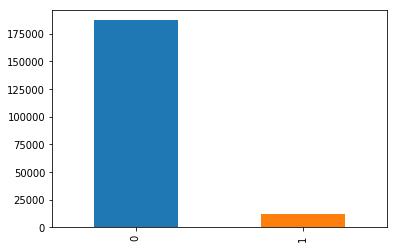

In [6]:
train_dataset["income"].value_counts().plot(kind='bar')

We can multiply by the instance weight for a more relevant repartition

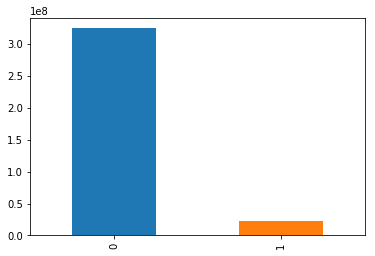

In [7]:
instance_weight_0 = train_dataset[train_dataset["income"]==0]["instance weight"]
instance_weight_1 = train_dataset[train_dataset["income"]==1]["instance weight"]
income_distribution = pd.Series([instance_weight_0.sum(), instance_weight_1.sum()])
income_distribution.plot(kind='bar')

We observe that people who earn less than 50K$ are way more present in the dataset. We're going to realize under sampling to obtain equivalent repartition of 0 and 1.

## Drop value - Under Sampling

In [8]:
#Drop value in the dataset.
train_dataset = drop_value_in_dataset(train_dataset, 0.08, 0)

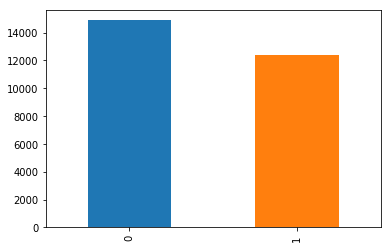

In [9]:
train_dataset["income"].value_counts().plot(kind='bar')

## Missing value

In [10]:
train_dataset.isin([' ?']).sum()

age                                               0
class of worker                                   0
industry code                                     0
occupation code                                   0
education                                         0
wage per hour                                     0
enrolled in edu inst last wk                      0
marital status                                    0
major industry code                               0
major occupation code                             0
race                                              0
hispanic Origin                                   0
sex                                               0
member of a labor union                           0
reason for unemployment                           0
full or part time employment stat                 0
capital gains                                     0
capital losses                                    0
divdends from stocks                              0
tax filer st

Here, we can observe the number of missing values for each column. From that, we can guess that migration code-change in msa, migration code-change in reg, migration code-move within reg and migration prev res in sunbelt have the same missing values. 

For these four columns, the best to do is probably to replace value by Not in universe values. However, this will give rise to a huge number of Not in universe value and so we will probably drop these columns as they don't bring lots of information

In [11]:
replace_value_in_dataset(train_dataset, 'migration code-change in msa', ' ?', ' Not in universe')
replace_value_in_dataset(train_dataset, 'migration code-change in reg', ' ?', ' Not in universe')
replace_value_in_dataset(train_dataset, 'migration code-move within reg', ' ?', ' Not in universe')
replace_value_in_dataset(train_dataset, 'migration prev res in sunbelt', ' ?', ' Not in universe')

Only 2 regions contains ? states. We're going to replace ? by the state that is the most represented in the region. This will work because there is no ' Not in universe' region when there is a state ?, when the region is ' Not in universe" the state is also ' Not in universe'

In [12]:
northeast_most_represented = train_dataset[train_dataset['region of previous residence']==' Northeast']['state of previous residence'].value_counts().index[0]
south_most_represented = train_dataset[train_dataset['region of previous residence']==' South']['state of previous residence'].value_counts().index[0]
missing_state = train_dataset[train_dataset['state of previous residence'] == ' ?']['state of previous residence']
region = train_dataset['region of previous residence']
for indice in missing_state.keys():
    if region.loc[indice] == ' Northeast':
        train_dataset['state of previous residence'].loc[indice] = northeast_most_represented
    elif region.loc[indice] == ' South':
        train_dataset['state of previous residence'].loc[indice] = south_most_represented


/home/clement/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


It will be really hard to guess country of birth father and mother. Given the solution, we can set the default value to United States.

In [13]:
replace_value_in_dataset(train_dataset, 'country of birth mother', ' ?', ' United-States')
replace_value_in_dataset(train_dataset, 'country of birth father', ' ?', ' United-States')

Finally, we can try to infer country of birth self depending on father and mother value. This can give rise to some error.

In [14]:
missing_country = train_dataset[train_dataset['country of birth self'] == ' ?']['country of birth self']
country_father = train_dataset['country of birth father']
country_mother = train_dataset['country of birth mother']
for indice in missing_country.keys():
    #if both parents have same country
    if country_father.loc[indice] == country_mother.loc[indice]:
        train_dataset['country of birth self'].loc[indice] = country_father.loc[indice]
    #If parents are from 2 different country, we set the default value to United states
    else:
        train_dataset['country of birth self'].loc[indice] = ' United-States'
    
    

/home/clement/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Feature Engineering

We now try to decide whether a column is relevant or not. This step of feature engineering is important to obtain a good model. Here, we're going to demonstrate the process only on some of the feature. We can see the final model in the modelisation part. It is important not to keep too many features to avoid overfitting.

## Age

,age,income
age,1.000000,0.316692
income,0.316692,1.000000


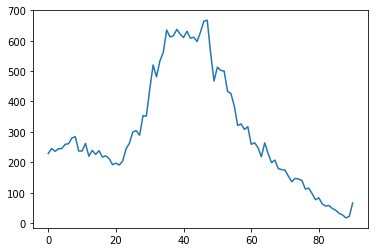

In [15]:
analyse_continuous_column(train_dataset, 'age')

In [16]:
train_dataset["age"].describe()

count    27264.000000
mean        39.513498
std         19.449666
min          0.000000
25%         28.000000
50%         40.000000
75%         52.000000
max         90.000000
Name: age, dtype: float64

It seems like the age have an impact on the output. So we're going to keep this column. Datas of this column seems to be coherent.

## Class of worker

,income,class of worker_ Federal government,class of worker_ Local government,class of worker_ Never worked,class of worker_ Not in universe,class of worker_ Private,class of worker_ Self-employed-incorporated,class of worker_ Self-employed-not incorporated,class of worker_ State government,class of worker_ Without pay
0,1.0,0.104885,0.067179,-0.028588,-0.489615,0.248718,0.184786,0.103039,0.060887,-0.019061


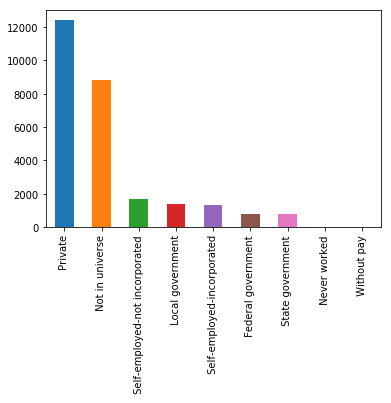

In [17]:
analyse_categorical_column(train_dataset, 'class of worker')

There are numerous "Not in universe" elements but we can see that some of the attribute impact the final income

## Industry code and occupation code

,income,major occupation code_ Adm support including clerical,major occupation code_ Armed Forces,major occupation code_ Executive admin and managerial,major occupation code_ Farming forestry and fishing,major occupation code_ Handlers equip cleaners etc,major occupation code_ Machine operators assmblrs & inspctrs,major occupation code_ Not in universe,major occupation code_ Other service,major occupation code_ Precision production craft & repair,major occupation code_ Private household services,major occupation code_ Professional specialty,major occupation code_ Protective services,major occupation code_ Sales,major occupation code_ Technicians and related support,major occupation code_ Transportation and material moving
0,1.0,-0.085501,0.011021,0.330397,-0.010352,-0.054311,-0.037689,-0.491298,-0.142751,0.05666,-0.041935,0.302243,0.056822,0.123466,0.053147,0.000303


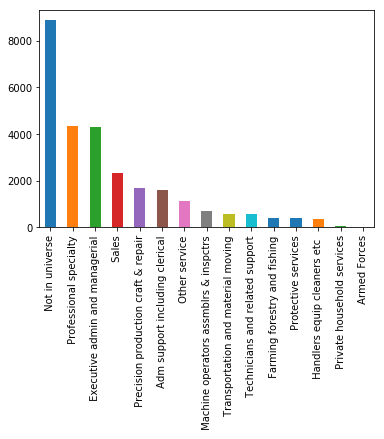

In [18]:
analyse_categorical_column(train_dataset, 'major occupation code')

Here we can clearly see that occupation have a huge impact on the final income. For instance, professional speciality people are more likely to earn more than 50k$ a year.

,income,major industry code_ Agriculture,major industry code_ Armed Forces,major industry code_ Business and repair services,major industry code_ Communications,major industry code_ Construction,major industry code_ Education,major industry code_ Entertainment,major industry code_ Finance insurance and real estate,major industry code_ Forestry and fisheries,major industry code_ Hospital services,major industry code_ Manufacturing-durable goods,major industry code_ Manufacturing-nondurable goods,major industry code_ Medical except hospital,major industry code_ Mining,major industry code_ Not in universe or children,major industry code_ Other professional services,major industry code_ Personal services except private HH,major industry code_ Private household services,major industry code_ Public administration,major industry code_ Retail trade,major industry code_ Social services,major industry code_ Transportation,major industry code_ Utilities and sanitary services,major industry code_ Wholesale trade
0,1.0,-0.000017,0.011021,0.063563,0.079233,0.042223,0.075278,-0.000416,0.134643,0.019577,0.059448,0.150224,0.084873,0.07121,0.057874,-0.491298,0.149838,-0.035059,-0.044062,0.116198,-0.032864,-0.033179,0.051943,0.067038,0.081616


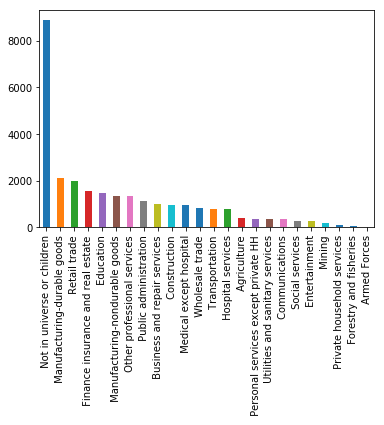

In [19]:
analyse_categorical_column(train_dataset, 'major industry code')

Here the importance of industry code seems to be less important that the occupation code but some of the factor are important so we can decide to also keep this column.

## Education


,income,education_ 10th grade,education_ 11th grade,education_ 12th grade no diploma,education_ 1st 2nd 3rd or 4th grade,education_ 5th or 6th grade,education_ 7th and 8th grade,education_ 9th grade,education_ Associates degree-academic program,education_ Associates degree-occup /vocational,education_ Bachelors degree(BA AB BS),education_ Children,education_ Doctorate degree(PhD EdD),education_ High school graduate,education_ Less than 1st grade,education_ Masters degree(MA MS MEng MEd MSW MBA),education_ Prof school degree (MD DDS DVM LLB JD),education_ Some college but no degree
0,1.0,-0.108087,-0.106105,-0.046022,-0.056762,-0.077037,-0.116109,-0.113314,0.036722,0.021685,0.29181,-0.36167,0.156338,-0.120376,-0.045501,0.24452,0.193131,0.006213


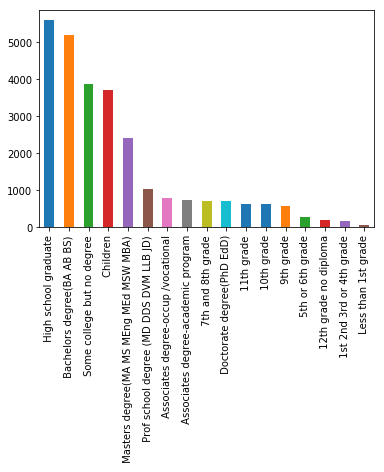

In [20]:
analyse_categorical_column(train_dataset, 'education')

This correlation line is very interesting, we can see the huge positive impact of studies on the income. Indeed coefficient of Bachelors, Masters and Doctorate are significantly greater than 0. It seems like the education brings some information so it is interesting to keep it.

## Wage per hour

,wage per hour,income
wage per hour,1.000000,0.045627
income,0.045627,1.000000


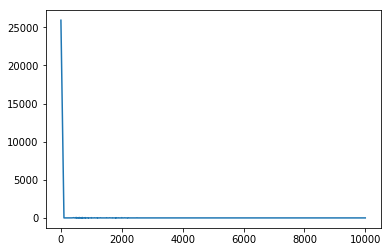

In [21]:
analyse_continuous_column(train_dataset, 'wage per hour')

It seems like a huge number of value are 0 so this column does not bring lots of information. We can drop this column.

## Marital Status

,income,marital status_ Divorced,marital status_ Married-A F spouse present,marital status_ Married-civilian spouse present,marital status_ Married-spouse absent,marital status_ Never married,marital status_ Separated,marital status_ Widowed
0,1.0,0.044696,-0.022447,0.378255,0.006504,-0.401814,-0.019337,-0.068262


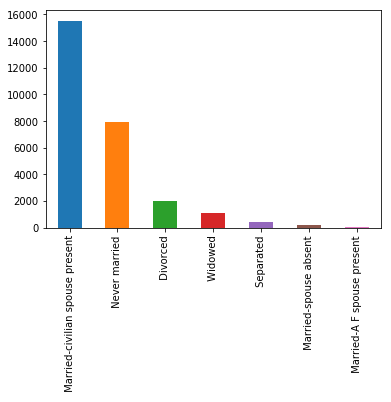

In [22]:
analyse_categorical_column(train_dataset, 'marital status')

It seems like the marital status has an impact on the output. We can keep this column

## Race

,income,race_ Amer Indian Aleut or Eskimo,race_ Asian or Pacific Islander,race_ Black,race_ Other,race_ White
0,1.0,-0.045471,0.016017,-0.120668,-0.052567,0.11814


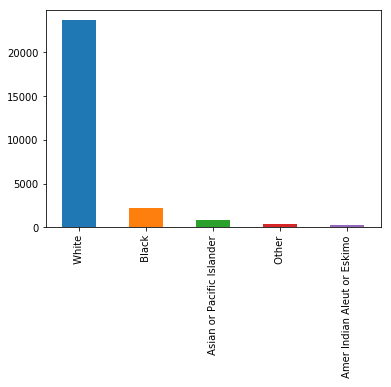

In [23]:
analyse_categorical_column(train_dataset, 'race')

The impact of this feature seems to be not so important but it is hard to determine whether this column should be drop or not.

## Tax filer status

,income,tax filer status_ Head of household,tax filer status_ Joint both 65+,tax filer status_ Joint both under 65,tax filer status_ Joint one under 65 & one 65+,tax filer status_ Nonfiler,tax filer status_ Single
0,1.0,-0.00188,-0.012803,0.402131,0.019689,-0.479919,-0.004769


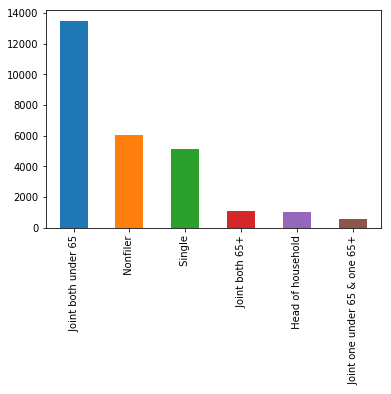

In [24]:
analyse_categorical_column(train_dataset, 'tax filer status')

According to this result, we can keep this column

## Sex

,income,sex_ Female,sex_ Male
0,1.0,-0.337856,0.337856


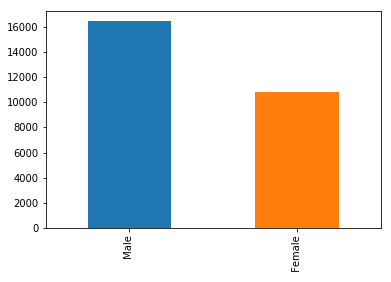

In [25]:
analyse_categorical_column(train_dataset, 'sex')

This correlation line clearly exposed differences in wages between male and female employees.

## full or part time employment stat

,income,full or part time employment stat_ Children or Armed Forces,full or part time employment stat_ Full-time schedules,full or part time employment stat_ Not in labor force,full or part time employment stat_ PT for econ reasons usually FT,full or part time employment stat_ PT for econ reasons usually PT,full or part time employment stat_ PT for non-econ reasons usually FT,full or part time employment stat_ Unemployed full-time,full or part time employment stat_ Unemployed part- time
0,1.0,-0.157998,0.267959,-0.17527,-0.000493,0.036281,0.057491,-0.034172,-0.029377


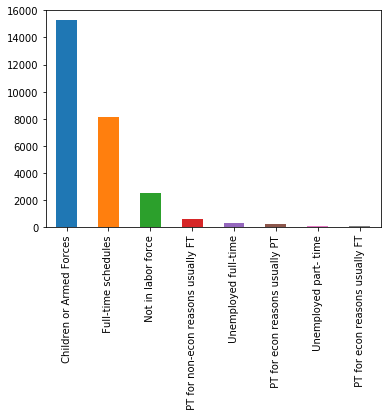

In [26]:
analyse_categorical_column(train_dataset, 'full or part time employment stat')

According to this result, it seems relevant to keep this column.

## Citizenship

,income,citizenship_ Foreign born- Not a citizen of U S,citizenship_ Foreign born- U S citizen by naturalization,citizenship_ Native- Born abroad of American Parent(s),citizenship_ Native- Born in Puerto Rico or U S Outlying,citizenship_ Native- Born in the United States
0,1.0,-0.059857,0.040833,0.016162,-0.031519,0.021134


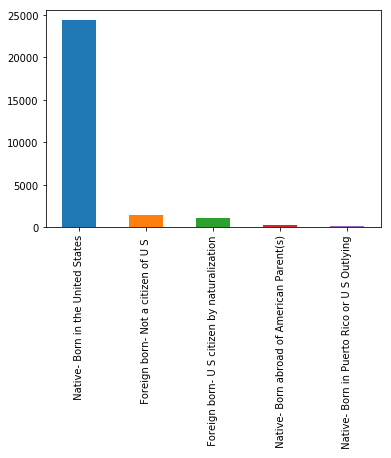

In [27]:
analyse_categorical_column(train_dataset, 'citizenship')

This column seems not to be really important to predict the output. We can probably drop this column.

## weeks worked in year

,weeks worked in year,income
weeks worked in year,1.000000,0.557883
income,0.557883,1.000000


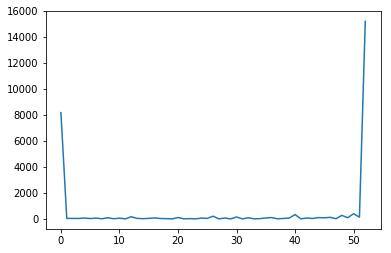

In [28]:
analyse_continuous_column(train_dataset, 'weeks worked in year')

# Step 3 : Modelisation

In [29]:
X_train = train_dataset[["education", "major industry code", "major occupation code", "class of worker", "age", 'num persons worked for employer', "weeks worked in year", 'race', "full or part time employment stat", "sex", "tax filer status", "marital status"]]
X_train = pd.get_dummies(X_train)
y_train = train_dataset["income"]

X_test = test_dataset[["education", "major industry code", "major occupation code", "class of worker", "age", 'num persons worked for employer', "weeks worked in year", 'race',  "full or part time employment stat", "sex", "tax filer status", "marital status"]]
X_test = pd.get_dummies(X_test)
y_test = test_dataset["income"]

add_missing_dummy_columns(X_train, X_test.columns)
add_missing_dummy_columns(X_test, X_train.columns)

clf = RandomForestClassifier(n_estimators=100, max_depth=55, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=55, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# Step 4 : Evaluate Performance 

In [30]:
y_predict = clf.predict(X_test)
generate_accuracy(y_predict, y_test)

0.8449910787674666

We obtain an accuracy of 84%. Let's look the accuracy for each category.

In [31]:
liste_of_bad_prediction = evaluate_bad_performance(y_predict, y_test)
true_value_repartition = pd.Series(y_test)
bad_prediction_repartition = pd.Series(liste_of_bad_prediction)

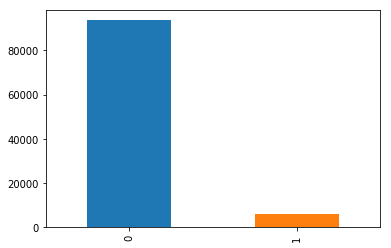

In [32]:
true_value_repartition.value_counts().plot(kind='bar')

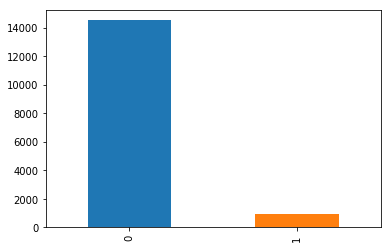

In [33]:
bad_prediction_repartition.value_counts().plot(kind='bar')

In [35]:
print(1 - bad_prediction_repartition.value_counts()[0]/true_value_repartition.value_counts()[0])
print(1 - bad_prediction_repartition.value_counts()[1]/true_value_repartition.value_counts()[1])

0.8449602462169787
0.8454574846427416


This is the repartition of 0 and 1 in our bad prediction. We can notice that the repartition is coherent and that we have the same accuracy on category 0 and 1.